# Open Source RAG - Leveraging Hugging Face Endpoints through LangChain

In the following notebook we will dive into the world of Open Source models hosted on Hugging Face's [inference endpoints](https://ui.endpoints.huggingface.co/).

The notebook will be broken into the following parts:

- 🤝 Breakout Room #2:
  1. Install required libraries
  2. Set Environment Variables
  3. Creating LangChain components powered by the endpoints
  4. Creating a simple RAG pipeline with [LangChain v0.2.0](https://blog.langchain.dev/langchain-v02-leap-to-stability/)

## Task 1: Install required libraries

Now we've got to get our required libraries!

We'll start with our `langchain` and `huggingface` dependencies.



In [1]:
!pip install -U langchain-huggingface langchain-community faiss-cpu

  Using cached langchain_huggingface-0.1.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached langchain_community-0.3.1-py3-none-any.whl.metadata (2.8 kB)
  Using cached faiss_cpu-1.8.0.post1-cp312-cp312-win_amd64.whl.metadata (3.8 kB)
  Using cached huggingface_hub-0.25.1-py3-none-any.whl.metadata (13 kB)
  Using cached langchain_core-0.3.8-py3-none-any.whl.metadata (6.3 kB)
  Using cached sentence_transformers-3.1.1-py3-none-any.whl.metadata (10 kB)
  Using cached tokenizers-0.20.0-cp312-none-win_amd64.whl.metadata (6.9 kB)
     ---------------------------------------- 0.0/44.4 kB ? eta -:--:--
     --------- ------------------------------ 10.2/44.4 kB ? eta -:--:--
     -------------------------------------- 44.4/44.4 kB 726.3 kB/s eta 0:00:00
  Using cached PyYAML-6.0.2-cp312-cp312-win_amd64.whl.metadata (2.1 kB)
  Using cached SQLAlchemy-2.0.35-cp312-cp312-win_amd64.whl.metadata (9.9 kB)
  Using cached aiohttp-3.10.8-cp312-cp312-win_amd64.whl.metadata (7.8 kB)
  Using cached datacl


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## Task 2: Set Environment Variables

We'll need to set our `HF_TOKEN` so that we can send requests to our protected API endpoint.

We'll also set-up our OpenAI API key, which we'll leverage later.



In [1]:
import os
# import getpass

# os.environ["HF_TOKEN"] = getpass.getpass("HuggingFace Write Token: ")

## Task 3: Creating LangChain components powered by the endpoints

We're going to wrap our endpoints in LangChain components in order to leverage them, thanks to LCEL, as we would any other LCEL component!

### HuggingFaceEndpoint for LLM

We can use the `HuggingFaceEndpoint` found [here](https://github.com/langchain-ai/langchain/blob/master/libs/community/langchain_community/llms/huggingface_endpoint.py) to power our chain - let's look at how we would implement it.

In [2]:
YOUR_LLM_ENDPOINT_URL = "https://gmw37aj9gqc6uly8.us-east-1.aws.endpoints.huggingface.cloud"

In [34]:
from langchain_community.llms import HuggingFaceEndpoint

hf_llm = HuggingFaceEndpoint(
    endpoint_url=f"{YOUR_LLM_ENDPOINT_URL}",
    max_new_tokens=512,
    top_k=10,
    top_p=0.95,
    typical_p=0.95,
    temperature=0.01,
    repetition_penalty=1.03,
    huggingfacehub_api_token=os.environ["HF_TOKEN"]
)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to C:\Users\novikova\.cache\huggingface\token
Login successful


Now we can use our endpoint like we would any other LLM!

In [35]:
hf_llm.invoke("Hello, how are you?")

" I am doing well, thanks for asking. I have been busy lately with work and other things, but I always make time for my blog. I have been thinking about what to write about next, and I have a few ideas. Let me know if any of these interest you:\n1. A review of the new iPhone: I recently got my hands on the latest iPhone model and I have been playing around with it. I can give you my thoughts on its features, performance, and overall user experience.\n2. A guide to cooking with cast iron: I have been experimenting with cooking with cast iron cookware and I have learned some tips and tricks that I would like to share with you. From seasoning to cooking techniques, I can provide you with a comprehensive guide.\n3. A travelogue of my recent trip to Japan: I recently returned from a trip to Japan and I have some amazing stories and photos to share with you. From the food to the culture, I can give you a glimpse into what it's like to travel in Japan.\n4. A review of the latest TV shows: I h

Now we can add a RAG-style prompt using Llama 3 Instruct's prompt templating!

In [5]:
from langchain_core.prompts import PromptTemplate

RAG_PROMPT_TEMPLATE = """\
<|start_header_id|>system<|end_header_id|>
You are a helpful assistant. You answer user questions based on provided context. If you can't answer the question with the provided context, say you don't know.<|eot_id|>

<|start_header_id|>user<|end_header_id|>
User Query:
{query}

Context:
{context}<|eot_id|>

<|start_header_id|>assistant<|end_header_id|>
"""

rag_prompt = PromptTemplate.from_template(RAG_PROMPT_TEMPLATE)

Let's create a simple LCEL chain using our prompt template Runnable and our LLM Runnable.

In [6]:
rag_chain = rag_prompt | hf_llm

In [7]:
rag_chain.invoke({"query" : "Who old is Carl?", "context" : "Carl is a sweet dude, he's 40."})

'Carl is 40 years old.'

### HuggingFaceInferenceAPIEmbeddings

Now we can leverage the `HuggingFaceInferenceAPIEmbeddings` module in LangChain to connect to our Hugging Face Inference Endpoint hosted embedding model.

In [8]:
from langchain_huggingface.embeddings import HuggingFaceEndpointEmbeddings

YOUR_EMBED_MODEL_URL = "https://u17dmgtovp8ob2ce.us-east-1.aws.endpoints.huggingface.cloud"

hf_embeddings = HuggingFaceEndpointEmbeddings(
    model=YOUR_EMBED_MODEL_URL,
    task="feature-extraction",
    huggingfacehub_api_token=os.environ["HF_TOKEN"],
)

Let's build a simple cosine-similarity function to verify our endpoint is working as expected.

In [9]:
import numpy as np
from numpy.linalg import norm

def cosine_similarity(phrase_1, phrase_2):
  vec_1 = hf_embeddings.embed_documents([phrase_1])[0]
  vec2_2 = hf_embeddings.embed_documents([phrase_2])[0]
  return np.dot(vec_1, vec2_2) / (norm(vec_1) * norm(vec2_2))

Let's try a few examples below!

In [10]:
cosine_similarity("I love my fluffy dog!", "I adore this furry puppy!")

0.8904885530282177

In [11]:
cosine_similarity("I love my fluffy dog!", "Eating pizza is the worst! Yuck!")

0.743418694322919

## Task 4: Preparing Data!

We'll start by loading some data from GitHub (Paul Graham's Essays) and then move to chunking them into manageable pieces!

First - let's grab the repository where the files live.

In [12]:
!git clone https://github.com/dbredvick/paul-graham-to-kindle.git

Cloning into 'paul-graham-to-kindle'...


Next - we can load them using LangChain!

In [13]:
from langchain_community.document_loaders import TextLoader

document_loader = TextLoader("./paul-graham-to-kindle/paul_graham_essays.txt")
documents = document_loader.load()

Now, let's split them into 1000 character pieces.

In [14]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=30)
split_documents = text_splitter.split_documents(documents)
len(split_documents)

4267

Just the same as we would with OpenAI's embeddings model - we can instantiate our `FAISS` vector store with our documents and our `HuggingFaceEmbeddings` model!

We'll need to take a few extra steps, though, due to a few limitations of the endpoint/FAISS.

We'll start by embeddings our documents in batches of `32`.

> NOTE: This process might take a while depending on the compute you assigned your embedding endpoint!

In [15]:
from langchain_community.vectorstores import FAISS

for i in range(0, len(split_documents), 32):
  if i == 0:
    vectorstore = FAISS.from_documents(split_documents[i:i+32], hf_embeddings)
    continue
  vectorstore.add_documents(split_documents[i:i+32])

Next, we set up FAISS as a retriever.

In [16]:
hf_retriever = vectorstore.as_retriever()

In [19]:
vectorstore.save_local("data.faiss")

In [25]:
new_vectorstore = FAISS.load_local("data.faiss", hf_embeddings, allow_dangerous_deserialization=True)

In [26]:
new_retriever = new_vectorstore.as_retriever()

In [28]:
hf_retriever.invoke("What is the best part of Silicon Valley?")

[Document(metadata={'source': './paul-graham-to-kindle/paul_graham_essays.txt'}, page_content="The best thing would be if the silicon valley were not merely closer to the interesting city, but interesting itself. And there is a lot of room for improvement here. Palo Alto is not so bad, but everything built since is the worst sort of strip development. You can measure how demoralizing it is by the number of people who will sacrifice two hours a day commuting rather than live there.  \n  \nAnother area in which you could easily surpass Silicon Valley is public transportation. There is a train running the length of it, and by American standards it's not bad. Which is to say that to Japanese or Europeans it would seem like something out of the third world.  \n  \nThe kind of people you want to attract to your silicon valley like to get around by train, bicycle, and on foot. So if you want to beat America, design a town that puts cars last. It will be a while before any American city can br

In [29]:
new_retriever.invoke("What is the best part of Silicon Valley?")

[Document(metadata={'source': './paul-graham-to-kindle/paul_graham_essays.txt'}, page_content="The best thing would be if the silicon valley were not merely closer to the interesting city, but interesting itself. And there is a lot of room for improvement here. Palo Alto is not so bad, but everything built since is the worst sort of strip development. You can measure how demoralizing it is by the number of people who will sacrifice two hours a day commuting rather than live there.  \n  \nAnother area in which you could easily surpass Silicon Valley is public transportation. There is a train running the length of it, and by American standards it's not bad. Which is to say that to Japanese or Europeans it would seem like something out of the third world.  \n  \nThe kind of people you want to attract to your silicon valley like to get around by train, bicycle, and on foot. So if you want to beat America, design a town that puts cars last. It will be a while before any American city can br

## Task 5: Simple LCEL RAG Chain

Now we can set up our LCEL RAG chain!

> NOTE: We're not returning context for this example, and only returning the text output from the LLM.

In [33]:
from operator import itemgetter
from langchain.schema.output_parser import StrOutputParser
from langchain.schema.runnable import RunnablePassthrough

lcel_rag_chain = {"context": itemgetter("query") | hf_retriever, "query": itemgetter("query")}| rag_prompt | hf_llm

In [32]:
lcel_rag_chain.invoke({"query" : "What is the best part of Silicon Valley?"})

'The best part of Silicon Valley, according to Paul Graham, is not the physical buildings, but the people. He emphasizes that the key stage in the life of a startup happens before they want large office spaces, and that the defining quality of Silicon Valley is that many successful startups were founded there.'

## Endpoint Usage screenshot

### Embeddings

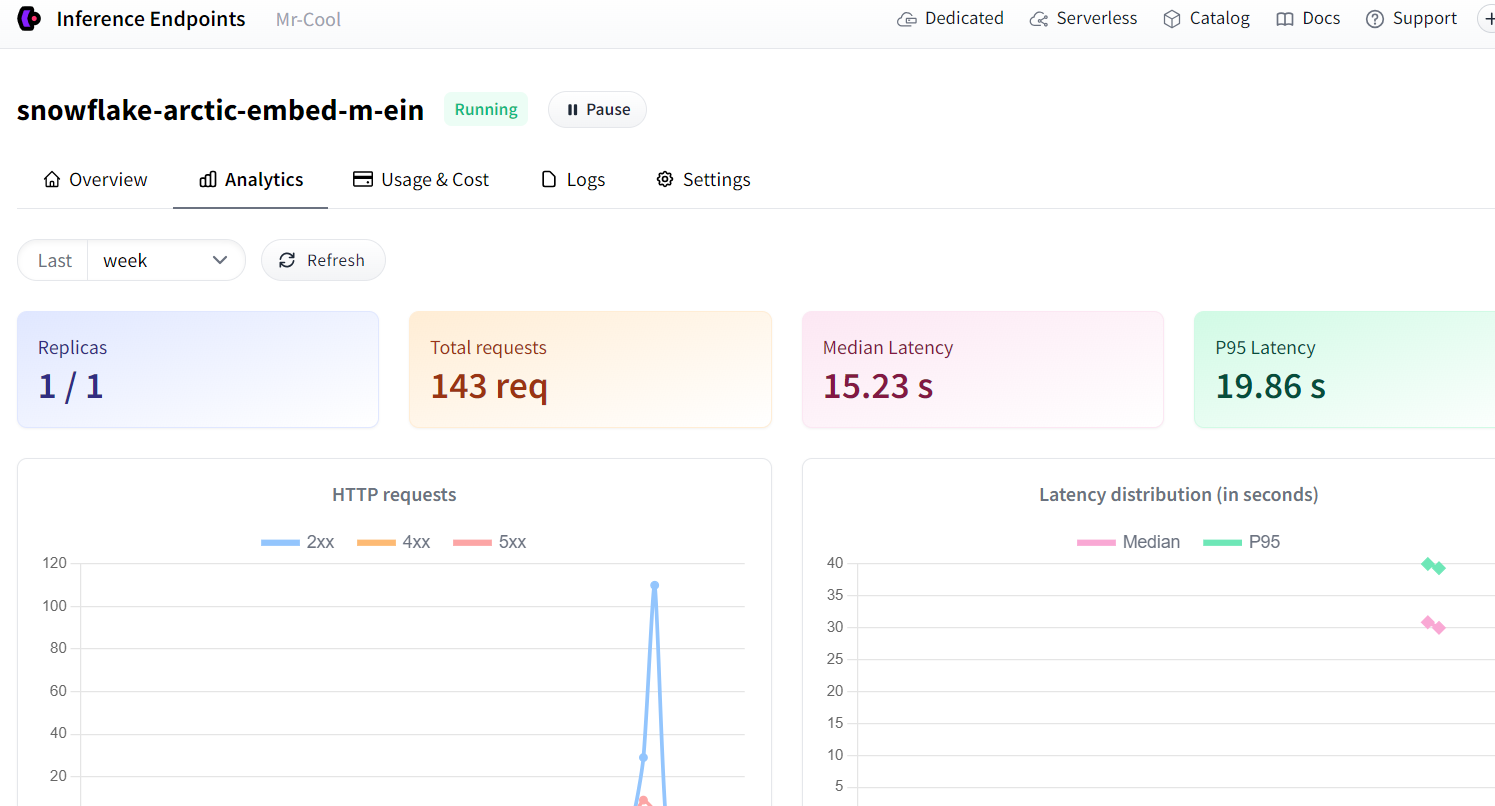

### Chat model

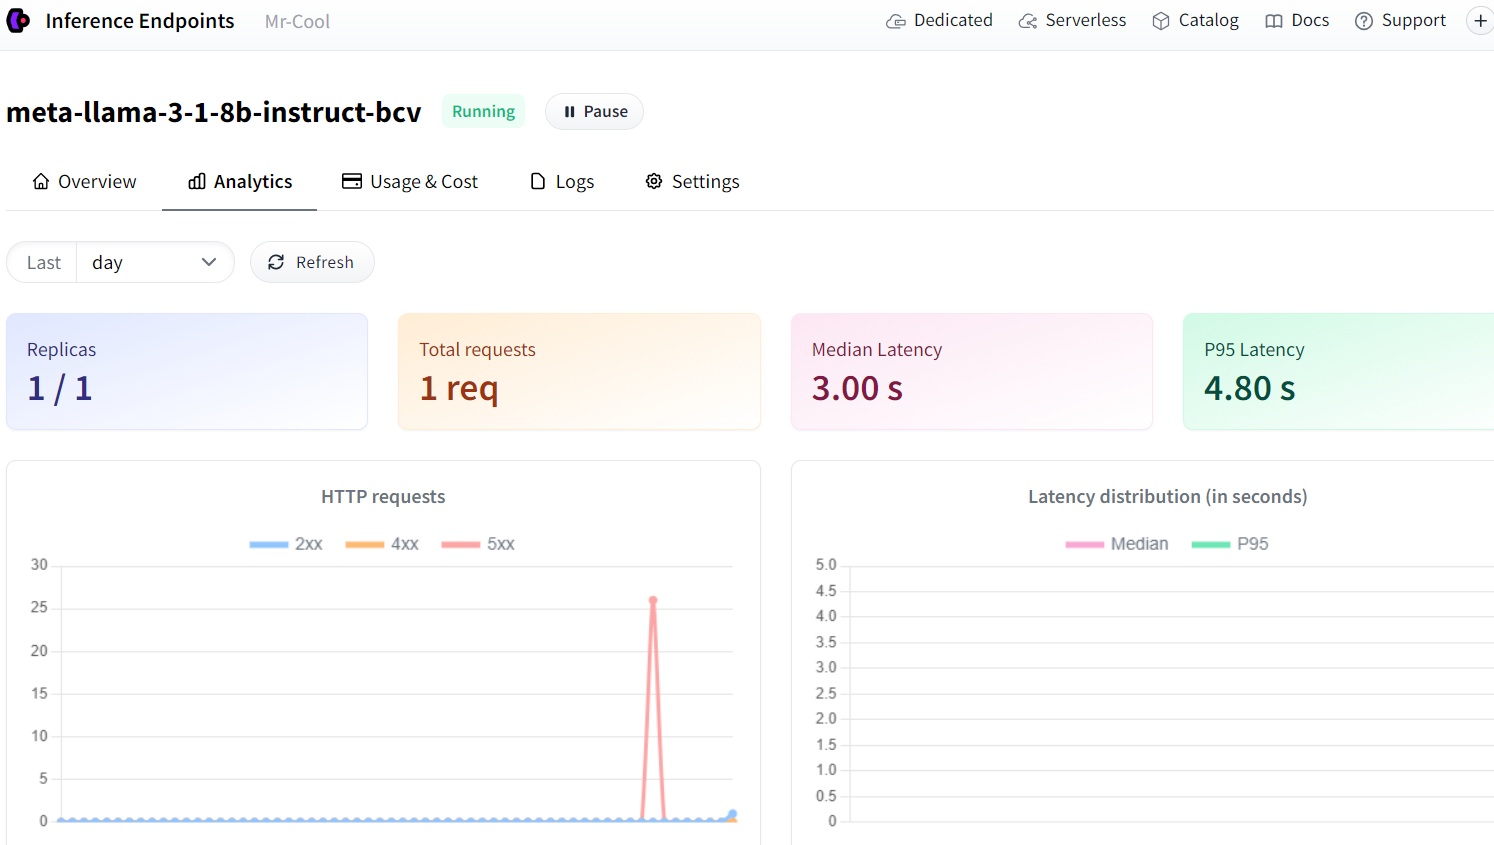

## App deployemnt

Click [here](https://huggingface.co/spaces/Mr-Cool/AIE4-W8D2)